# Modeling
In this notebook I will create some deep learning models to address the colorization task.

In [12]:
import pandas as pd
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from tqdm import tqdm

In [105]:
dataset_path = "../preprocessed/"
path = '../../dataset/'
models_path = "../../models/"
results_path = "../../results/"

In [23]:
N = 25000
W = 128
H = 128

## Load datasets

In [29]:
resized = []
grayscaled = []

In [30]:
for f in tqdm(os.listdir(dataset_path+"resized/")):
    resized = np.append(resized,np.load(dataset_path+"resized/"+f)["arr_0"])

 72%|██████████████████████████████████████████████████████████▎                      | 72/100 [03:28<01:21,  2.90s/it]


KeyboardInterrupt: 

In [ ]:
assert resized.shape == (N,W,H,3)

## Models

In [59]:
from keras.layers import Conv2D, UpSampling2D
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from skimage.color import rgb2lab, lab2rgb
from skimage.transform import resize
from skimage.io import imsave, imshow
import numpy as np
import tensorflow as tf

In [92]:
#Normalize images - divide by 255
train_datagen = ImageDataGenerator(rescale=1. / 255)

#Resize images, if needed
train = train_datagen.flow_from_directory(path, 
                                          target_size=(256, 256), 
                                          batch_size=340, 
                                          class_mode=None)

Found 29344 images belonging to 4 classes.


In [95]:
#Convert from RGB to Lab
"""
by iterating on each image, we convert the RGB to Lab. 
Think of LAB image as a grey image in L channel and all color info stored in A and B channels. 
The input to the network will be the L channel, so we assign L channel to X vector. 
And assign A and B to Y.
"""

X =[]
Y =[]
for img in train[2]:
    try:
        lab = rgb2lab(img)
        X.append(lab[:,:,0]) 
        Y.append(lab[:,:,1:] / 128) #A and B values range from -127 to 128, 
        #so we divide the values by 128 to restrict values to between -1 and 1.
    except:
        print('error')
        
X = np.array(X)
Y = np.array(Y)
X = X.reshape(X.shape+(1,)) #dimensions to be the same for X and Y
print(X.shape)
print(Y.shape)

(340, 256, 256, 1)
(340, 256, 256, 2)


In [96]:
#Encoder

model = Sequential("AE_Complex")
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2, input_shape=(256, 256, 1)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Conv2D(128, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same', strides=2))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(512, (3,3), activation='relu', padding='same'))
model.add(Conv2D(256, (3,3), activation='relu', padding='same'))

#Decoder
#Decoder
#Note: For the last layer we use tanh instead of Relu. 
#This is because we are colorizing the image in this layer using 2 filters, A and B.
#A and B values range between -1 and 1 so tanh (or hyperbolic tangent) is used
#as it also has the range between -1 and 1. 
#Other functions go from 0 to 1.
model.add(Conv2D(128, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3,3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3,3), activation='relu', padding='same'))
model.add(Conv2D(16, (3,3), activation='relu', padding='same'))
model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))
model.compile(optimizer='adam', loss='mse' , metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_13 (Conv2D)           (None, 128, 128, 64)      640       
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 128)       147584    
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 64, 64, 256)       295168    
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 32, 32, 256)       590080    
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 32, 32, 512)       1180160   
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 32, 32, 512)      

In [99]:
history = model.fit(X,Y,validation_split=0.1, epochs=5, batch_size=16)

Epoch 1/5
20/20 [==============================] - 100s 5s/step - loss: 0.0343 - accuracy: 0.5283 - val_loss: 0.0176 - val_accuracy: 0.6124
Epoch 2/5
20/20 [==============================] - 123s 6s/step - loss: 0.0177 - accuracy: 0.6440 - val_loss: 0.0181 - val_accuracy: 0.6124
Epoch 3/5
20/20 [==============================] - 122s 6s/step - loss: 0.0176 - accuracy: 0.6445 - val_loss: 0.0173 - val_accuracy: 0.6124
Epoch 4/5
20/20 [==============================] - 122s 6s/step - loss: 0.0176 - accuracy: 0.6445 - val_loss: 0.0175 - val_accuracy: 0.6124
Epoch 5/5
20/20 [==============================] - 122s 6s/step - loss: 0.0174 - accuracy: 0.6445 - val_loss: 0.0196 - val_accuracy: 0.6124


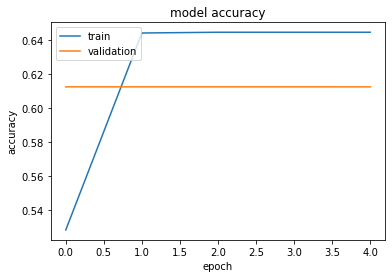

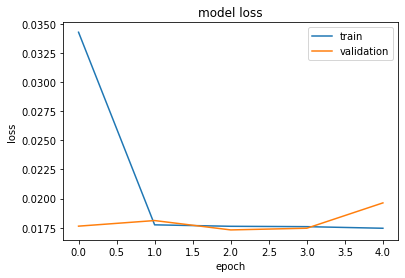

In [102]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [44]:
model.save(models_path+model.name)

INFO:tensorflow:Assets written to: colorize_autoencoder.model\assets


In [ ]:
model_name = model.name
model = tf.keras.models.load_model(
    models_path+model_name,
    custom_objects=None,
    compile=True)

In [103]:
def plot_comparison(img_resized,img_recolored):     
    fig, axes = plt.subplots(1, 2, figsize=(8, 4))
    ax = axes.ravel()

    ax[0].imshow(img_resized.astype('uint8'))
    ax[0].set_title("Resized")
    ax[1].imshow(img_recolored)
    ax[1].set_title("Recolored")

    fig.tight_layout()
    plt.show()      

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


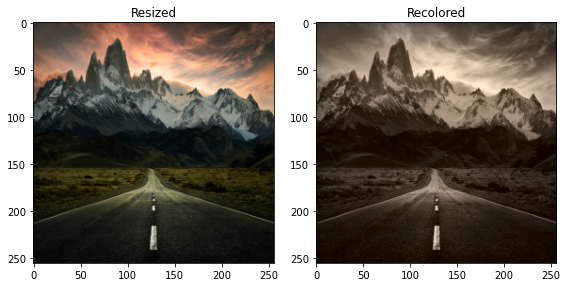

In [107]:
img1_color=[]
img1=img_to_array(load_img(path+'download/landscapes/landscapes_6.jpeg'))
img1 = resize(img1 ,(256,256))
img1_color.append(img1)
img1_color = np.array(img1_color, dtype=float)
img1_color = rgb2lab(1.0/255*img1_color)[:,:,:,0]
img1_color = img1_color.reshape(img1_color.shape+(1,))

output1 = model.predict(img1_color)
output1 = output1*128
result = np.zeros((256, 256, 3))
result[:,:,0] = img1_color[0][:,:,0]
result[:,:,1:] = output1[0]

imsave("result.png", lab2rgb(result))
recolored = lab2rgb(result)
plot_comparison(img1, recolored)

## Training

## Validation

## Testing